In [1]:
import pandas as pd

import numpy as np

import os

import cv2

import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Грузим данные 

1. Таблички

In [3]:
open_part = pd.read_csv("Dataset/OpenPart.csv")
shapes = pd.read_csv("Dataset/DX_TEST_RESULT_FULL.csv")

[]

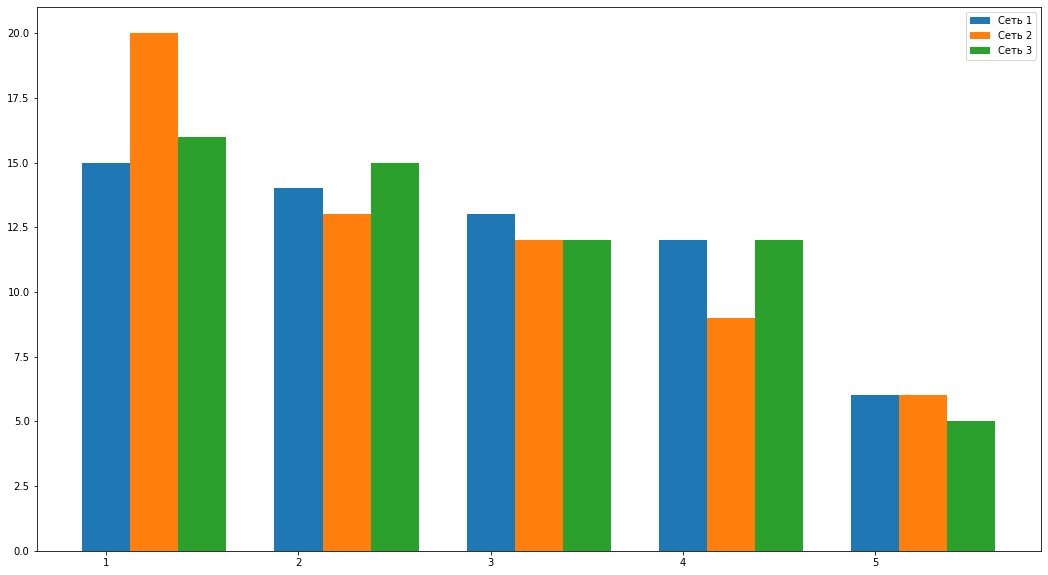

In [4]:
plt.figure(figsize=(18,10))
ind = np.arange(1, 6)
plt.bar(ind, open_part["Sample 1"].value_counts(), label="Сеть 1",  width = 0.25)
plt.bar(ind + 0.25, open_part["Sample 2"].value_counts(), label="Сеть 2",  width = 0.25)
plt.bar(ind + 0.50, open_part["Sample 3"].value_counts(), label="Сеть 3",  width = 0.25)
plt.legend(loc="upper right")
plt.plot()

2. Изображения

In [31]:
samples = {}

for sample in range(1,4):
    temp_names = os.listdir(f"Dataset/sample_{sample}/")
    img_buffer = []
    for img_name in temp_names:
        img_buffer.append(cv2.imread(f"Dataset/sample_{sample}/{img_name}"))
    samples[f"sample_{sample}"] = img_buffer

In [32]:
print(len(samples["sample_1"]), len(samples["sample_2"]), len(samples["sample_3"]))

100 100 100


In [33]:
origin = []

temp_names = os.listdir(f"Dataset/Origin/")
for img_name in temp_names:
    origin.append(cv2.imread(f"Dataset/Origin/{img_name}"))

In [34]:
print(len(origin))

100


In [37]:
expert = []

temp_names = os.listdir(f"Dataset/Expert/")
for img_name in temp_names:
    expert.append(cv2.imread(f"Dataset/Expert/{img_name}"))
del temp_names

In [38]:
print(len(expert))

100


Сопоставляем имена и названия файлов

In [40]:
print("Проверка масок, Оригинальных изображений")
mismatch = 0

for sample in samples.keys():
    for img in range(len(samples[sample])):
        if samples[sample][img].shape != samples[sample][img].shape:
            mismatch += 1
            
for orig in range(len(origin)):
    if origin[orig].shape != origin[0].shape:
        mismatch += 1
    
for exp in range(len(expert)):
    if expert[exp].shape != expert[0].shape:
        mismatch += 1
    
print(f"Форма в разметке не совпадает в {mismatch} случаев")

Проверка масок, Оригинальных изображений
Форма в разметке не совпадает в 0 случаев
